# Online Learning of a Dictionary of Parts of Faces

This example uses a large dataset of faces to learn a set of $20\times20$ images patches that constitute faces.

From the programming standpoint, it is interesting because it shows how to use the online API of `scikit-learn` to process a very large dataset in chunks. The way we proceed is that we load an image at a time and extract randomly 50 patches from this image. Once we accumulated 500 of these patches (using 10b images), we run the `partial_fit` method of the online `KMeans` object, `MiniBatchKMeans`.

The `verbose` setting on the `MinBatchKMeans` enables us to see that some clusters are reassigned during the successive calls to `partial-fit`. This is because the number of patches that they represent has become too low, and it is better to choose a random new cluster.

In [1]:
from sklearn import datasets

faces = datasets.fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /Users/lsantos/scikit_learn_data


## Learn the dictionary of images

In [2]:
import time

import numpy as np

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.image import extract_patches_2d

print("Learning the dictionary... ")
rng = np.random.RandomState(0)
kmeans = MiniBatchKMeans(n_clusters=81, random_state=rng, verbose=True)
patch_size = (20, 20)

buffer = []
t0 = time.time()

# The online learning part: cycle over the whole dataset 6 times
index = 0
for _ in range(6):
    for img in faces.images:
        
        # extract parts of the image, flatten, then add to the buffer list
        data = extract_patches_2d(img, patch_size, max_patches=50, random_state=rng)
        data = np.reshape(data, (len(data), -1))
        buffer.append(data)
        index += 1
        
        # for every 10 patches, aggregate the buffer, scale it, then perform a partial_fit using the MiniBatchKmeans
        # then reset the buffer
        if index % 10 == 0:
            data = np.concatenate(buffer, axis=0)
            data -= np.mean(data, axis=0)
            data /= np.std(data, axis=0)
            kmeans.partial_fit(data)
            buffer = []
        if index % 100 == 0:
            print("Partial fit of %4i out of %i" % (index, 6 * len(faces.images)))

dt = time.time() - t0
print("done in %.2fs." % dt)

Learning the dictionary... 
[MiniBatchKMeans] Reassigning 6 cluster centers.
[MiniBatchKMeans] Reassigning 3 cluster centers.
Partial fit of  100 out of 2400
[MiniBatchKMeans] Reassigning 3 cluster centers.
[MiniBatchKMeans] Reassigning 2 cluster centers.
Partial fit of  200 out of 2400
[MiniBatchKMeans] Reassigning 1 cluster centers.
[MiniBatchKMeans] Reassigning 1 cluster centers.
Partial fit of  300 out of 2400
Partial fit of  400 out of 2400
Partial fit of  500 out of 2400
Partial fit of  600 out of 2400
Partial fit of  700 out of 2400
Partial fit of  800 out of 2400
Partial fit of  900 out of 2400
Partial fit of 1000 out of 2400
Partial fit of 1100 out of 2400
Partial fit of 1200 out of 2400
Partial fit of 1300 out of 2400
Partial fit of 1400 out of 2400
Partial fit of 1500 out of 2400
Partial fit of 1600 out of 2400
Partial fit of 1700 out of 2400
Partial fit of 1800 out of 2400
Partial fit of 1900 out of 2400
Partial fit of 2000 out of 2400
Partial fit of 2100 out of 2400
Partia

## Plot the results

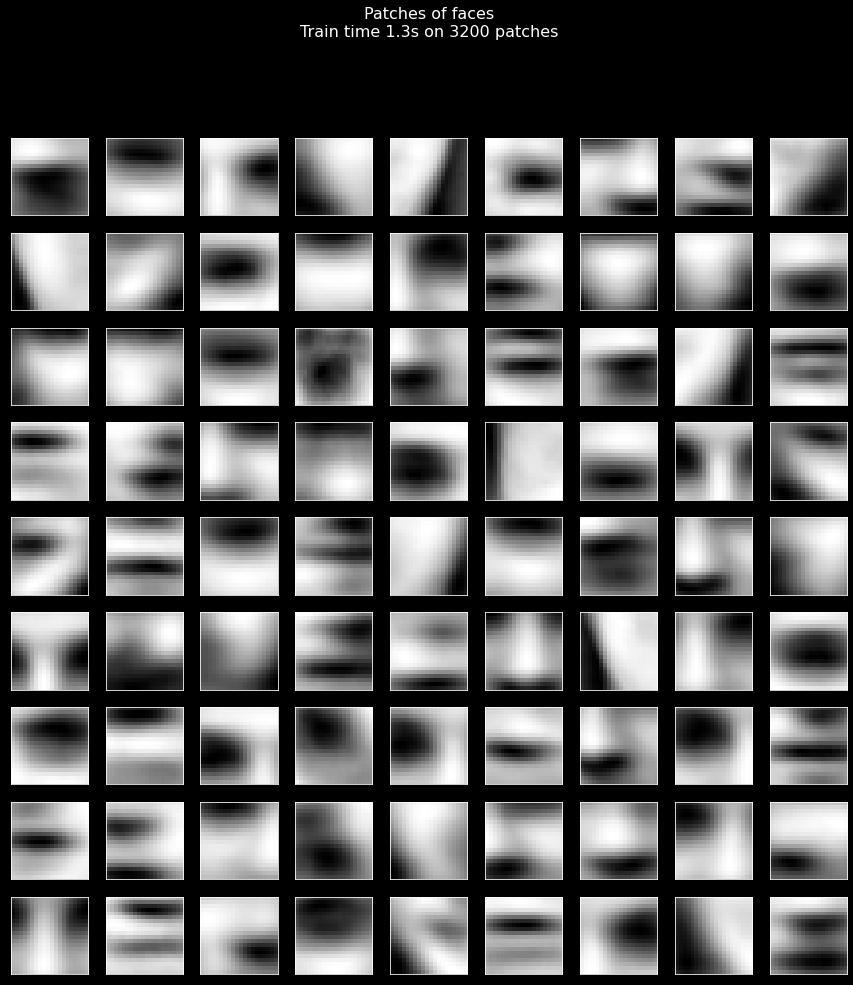

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 14))
for i, patch in enumerate(kmeans.cluster_centers_):
    plt.subplot(9, 9, i + 1)
    plt.imshow(patch.reshape(patch_size), cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())


plt.suptitle(
    "Patches of faces\nTrain time %.1fs on %d patches" % (dt, 8 * len(faces.images)),
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()